# Exam - Advanced Methods in Applied Statistics 2024 - Emilie Jessen

## Problem 1 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from iminuit import Minuit
import nestle
import corner

In [2]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite'}
mpl.rc('axes', **axes)

# Add grid
mpl.rc('axes', grid=True)

# Set custom color cycle
custom_colors= ['orange', 'red', 'limegreen', 'orange', 'orchid', 'black', 'slategrey', 
                'navy', 'magenta', 'forestgreen', 'lightblue', 'maroon', 'gold', 'lightcoral', 
                'mediumseagreen', 'darkorange', 'darkviolet', 'dimgray', 'darkblue', 'darkred',]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Set inside tickmarks
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [3]:
save_plots = True
np.random.seed(42)

### Problem 1a

Solution inspired by the Exam 2016 Solutions and by Sophia Wilson's Github repository: 

https://github.com/sophiawilson18/AdvAppStat/tree/main

In [4]:
data = np.loadtxt('Data/Exam_2024_Prob1.txt')

In [5]:
# Getting the data from the first, third and fourth columns

x1 = data[:,0]
x3 = data[:,2]
x4 = data[:,3]

# Sort the data
x1 = np.sort(x1)
x3 = np.sort(x3)
x4 = np.sort(x4)

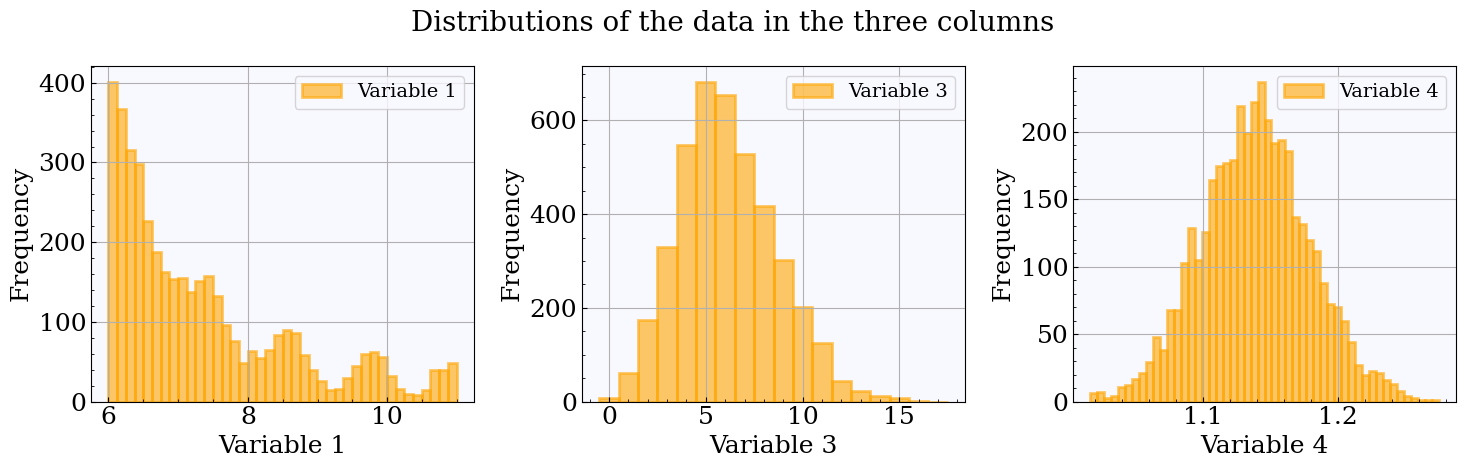

In [6]:
# Plot the distributions of the data in the three columns

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
title = fig.suptitle('Distributions of the data in the three columns', fontsize=20)
title.set_position([.5, 0.95])

ax[0].hist(x1, bins=40, alpha=0.6, edgecolor='orange', lw=2)
ax[0].set(xlabel='Variable 1', 
          ylabel='Frequency')
ax[0].legend(['Variable 1'], fontsize=14)

ax[1].hist(x3, bins=np.arange(-0.5, x3.max(), 1),  alpha=0.6, edgecolor='orange', lw=2)
ax[1].set(xlabel='Variable 3', 
          ylabel='Frequency')
ax[1].legend(['Variable 3'], fontsize=14)

ax[2].hist(x4, bins=50, alpha=0.6, edgecolor='orange', lw=2)
ax[2].set(xlabel='Variable 4', 
          ylabel='Frequency')
ax[2].legend(['Variable 4'], fontsize=14)

fig.tight_layout()

if save_plots:
    plt.savefig('Figures/Prob1_Dist.png')

In [7]:
# Define arrays for the data in the three columns
x1_arr = np.linspace(6, 11, 1000)
x3_arr = np.linspace(x3.min(), x3.max(), 1000)
x4_arr = np.linspace(x4.min(), x4.max(), 1000)

# Define the bounds on the parameter values given in the assignment
params_bounds = np.array([[-10, 10], [-10, 10], [4000, 8000]])

In [9]:
# Fit first distribution with nested samling

def func1(x, a, b, c):
    func = np.sin(a * x) + c * np.exp(b*x) + 1
    norm = np.trapz(np.sin(a * x1_arr) + c * np.exp(b*x1_arr) + 1, x1_arr)
    return func / norm

def loglike(params):
    model = func1(np.sort(x1), *params)
    llh = np.sum(np.log(model))
    return llh

def prior_transform(params):
    return params_bounds[:, 0] + (params_bounds[:, 1] - params_bounds[:, 0]) * params

ndim = 3
nlive = 500

result = nestle.sample(loglike, prior_transform, ndim, npoints=nlive)

In [10]:
# Get number of samples
n_samples = result.samples.shape[0]

# Print the number of samples
print(f'Number of samples: {n_samples}')

Number of samples: 7971


In [11]:
# Get the maximum likelihood parameters
a_best, b_best, c_best = result.samples[np.argmax(result.logl)]

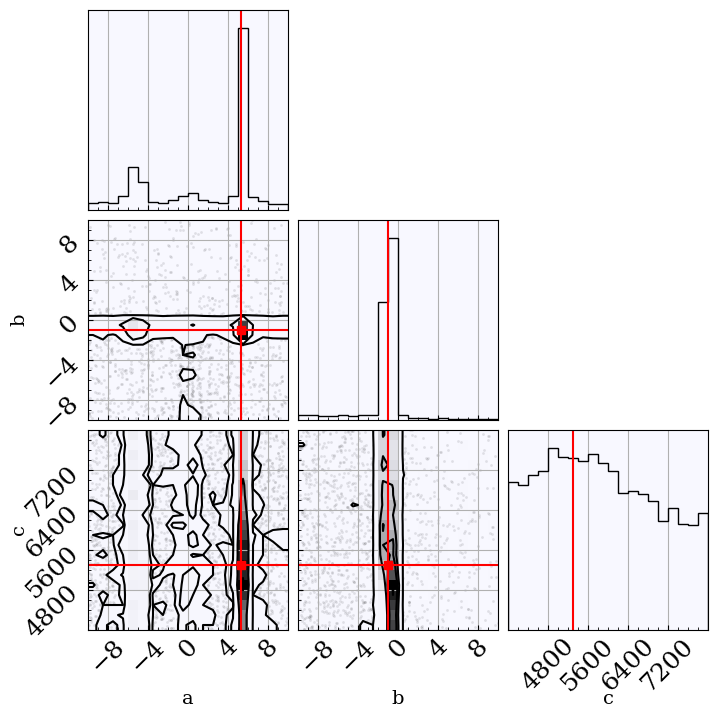

In [12]:
# Plot corner plot of the results

fig = corner.corner(result.samples, labels=['a', 'b', 'c'], truths=[a_best, b_best, c_best],
                    truth_color='red', label_kwargs={'fontsize': 14})  

if save_plots:
    plt.savefig('Figures/Prob1_Corner1.png')

In [13]:
# Get the maximum likelihood parameters
a_best, b_best, c_best = result.samples[np.argmax(result.logl)]

# From the samples do a booststrap to get the errors

limit = (100 - 68.27) / 2 / 100

a_samples = np.sort(result.samples[:, 0])
b_samples = np.sort(result.samples[:, 1])
c_samples = np.sort(result.samples[:, 2])

a_low = a_samples[int(limit * n_samples)]
a_high = a_samples[int((1 - limit) * n_samples)]

b_low = b_samples[int(limit * n_samples)]
b_high = b_samples[int((1 - limit) * n_samples)]

c_low = c_samples[int(limit * n_samples)]
c_high = c_samples[int((1 - limit) * n_samples)]

a_pos_err = a_high - a_best
a_neg_err = a_best - a_low

b_pos_err = b_high - b_best
b_neg_err = b_best - b_low

c_pos_err = c_high - c_best
c_neg_err = c_best - c_low

# Print the results
print('Results for the first distribution:')
print(f'a = {a_best:.3f} + {a_pos_err:.3f} - {a_neg_err:.3f}')
print(f'b = {b_best:.3f} + {b_pos_err:.3f} - {b_neg_err:.3f}')
print(f'c = {c_best:.3f} + {c_pos_err:.3f} - {c_neg_err:.3f}')

Results for the first distribution:
a = 5.298 + 0.021 - 10.882
b = -0.989 + 0.284 - 0.077
c = 5291.350 + 1888.852 - 673.927


In [14]:
def chi2_test(data, bins, xmin, xmax, fit_pdf, params): 
    '''Performs Chi2-test on histogram without zerobins'''
    
     #Creating histogram without zero-bins
    counts, bin_edges = np.histogram(data, bins=bins, range=(xmin, xmax))
    bin_width = bin_edges[1] - bin_edges[0]

    mask = counts > 0 
    x = (bin_edges[1:][mask] + bin_edges[:-1][mask])/2
    y = counts[mask]
    sy = np.sqrt(y)  # Assuming the bin count is Poisson distributed.
    
    # Calculate the expected values (N*binwidth unnormalises it so it fits the histogram)
    y_exp = fit_pdf(x, *params) * len(data) * bin_width 

    # Degrees of freedom
    N_ddof = len(x) - len(params) #bins - n_parameters

    # Calc chi2 and p value
    chi2 = np.sum((y - y_exp)**2 / y_exp) # y_exp = y_err^2
    chi2_reduced = chi2 / N_ddof
    prob = scipy.stats.chi2.sf(chi2, df=N_ddof) 
    print(f'The reduced Chi2 is: {chi2_reduced:.4f} with a p-value of: {prob:.4f}')
    
    return chi2_reduced, prob, bin_width

In [15]:
# Perform Chi2-test on the first distribution
chi2_reduced1, prob1, bin_width1 = chi2_test(x1, 40, 6, 11, func1, np.array([a_best, b_best, c_best]))

The reduced Chi2 is: 0.8673 with a p-value of: 0.6983


In [16]:
# Fit second distribution with Poisson distribution using Minuit

def func3(k, lambd):
    func = scipy.stats.poisson.pmf(k, lambd)
    return func

def fit_obj3(lambd):
    model = func3(x3, lambd)
    llh = np.sum(np.log(model))
    return -llh

m3 = Minuit(fit_obj3, lambd=5)
m3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9565                       │              Nfcn = 17               │
│ EDM = 2.77e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lambd │   6.12    │   0.05    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────┐
│       │   lambd │
├───────┼─────────┤
│ lambd │ 0.00297 │
└───────┴─────────┘

In [25]:
# Print the result of minimization
print('The best fit value for the second distribution is:')
print('lambda =', m3.values['lambd'])

# Perform Chi2-test on the second distribution
chi2_reduced2, prob2, bin_width2 = chi2_test(x3, np.arange(-0.5, 30, 1), x3.min(), x3.max(), func3, np.array([m3.values['lambd']]))

The best fit value for the second distribution is:
lambda = 6.117661243312717
The reduced Chi2 is: 1.3398 with a p-value of: 0.1567


In [19]:
# Fit third distribution with Gaussian distribution using Minuit

def func4(x, mu, sigma):
    func = scipy.stats.norm.pdf(x, mu, sigma)
    return func

def fit_obj4(mu, sigma):
    model = func4(x4, mu, sigma)
    llh = np.sum(np.log(model))
    return -llh

m4 = Minuit(fit_obj4, mu=1.15, sigma=0.2)
m4.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7432                      │              Nfcn = 66               │
│ EDM = 2.7e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  1.1386   │  0.0009   │            │            │         │         │       │
│ 1 │ sigma │  39.9e-3  │  0.6e-3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 7.71e-07 3.55e-10 │
│ sigma │ 3.55e-10 3.86e-07 │
└───────┴───────────────────┘

In [20]:
# Print the result of minimization
print('The best fit values for the third distribution are:')
print('mu =', m4.values['mu'])
print('sigma =', m4.values['sigma'])

# Perform Chi2-test on the third distribution
chi2_reduced3, prob3, bin_width3 = chi2_test(x4, 50, x4.min(), x4.max(), func4, np.array([m4.values['mu'], m4.values['sigma']]))

The best fit values for the third distribution are:
mu = 1.1385877718676225
sigma = 0.03985828877237895
The reduced Chi2 is: 1.1866 with a p-value of: 0.1762


### Problem 1b 

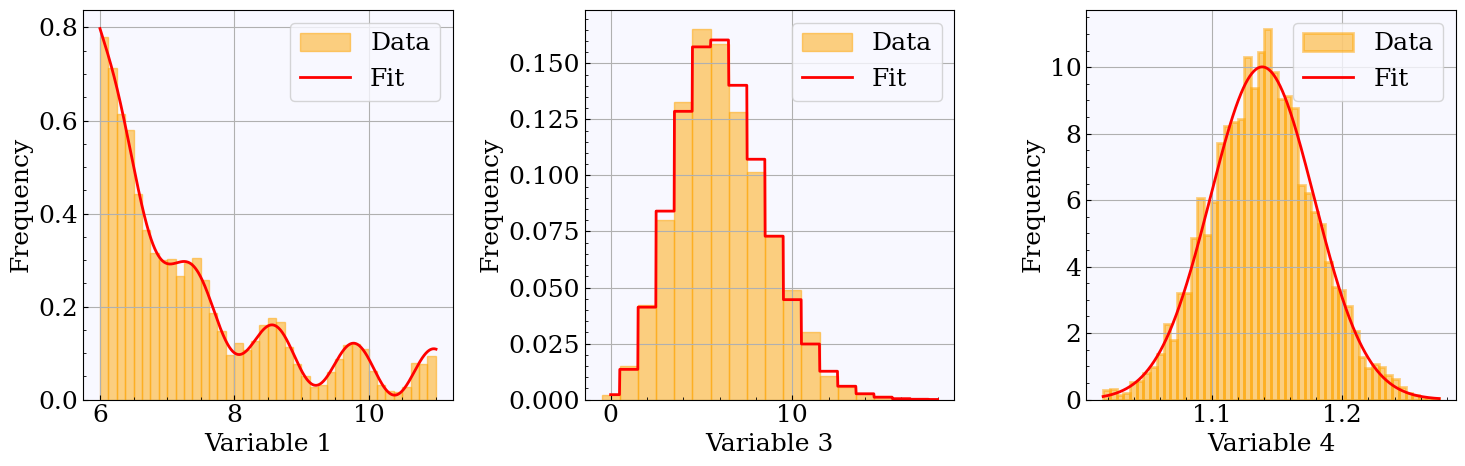

In [21]:
# Plot all the fits

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(x1, bins=40, density=True, alpha=0.5, edgecolor='orange', label='Data')
ax[0].plot(x1_arr, func1(x1_arr, a_best, b_best, c_best), lw=2, label='Fit')

ax[0].set(xlabel='Variable 1',
            ylabel='Frequency')
ax[0].legend()

ax[1].hist(x3, bins=np.arange(-0.5, x3.max(), 1), density=True, alpha=0.5, edgecolor='orange', label='Data')
ax[1].plot(x3_arr, func3(np.floor(x3_arr+0.5), *m3.values[:]), lw=2, label='Fit')

ax[1].set(xlabel='Variable 3',
            ylabel='Frequency')
ax[1].legend(loc='upper right')

ax[2].hist(x4, bins=50, density=True, alpha=0.5, edgecolor='orange', lw=2, label='Data')
ax[2].plot(x4_arr, func4(x4_arr, *m4.values[:]), lw=2, label='Fit')

ax[2].set(xlabel='Variable 4',
            ylabel='Frequency')
ax[2].legend()

fig.tight_layout()

if save_plots:
    plt.savefig('Figures/Fig_1_2.pdf')     

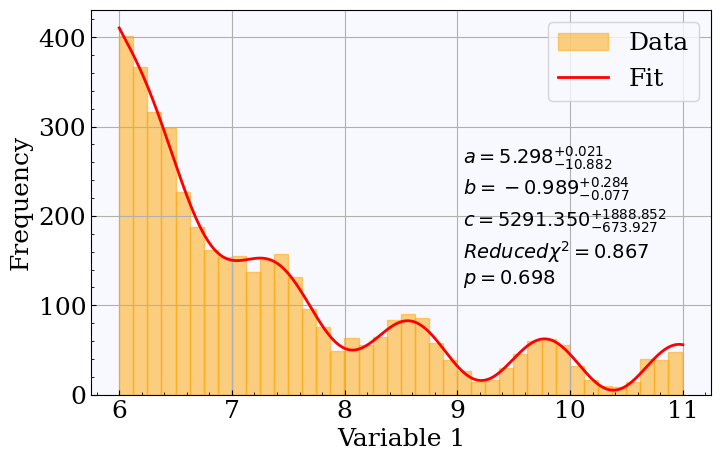

In [22]:
# Plot the first fit with the fit parameters

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

hist = ax.hist(x1, bins=40, alpha=0.5, edgecolor='orange', label='Data')
bw = hist[1][1] - hist[1][0]
ax.plot(x1_arr, len(x1) * bw * func1(x1_arr, a_best, b_best, c_best), lw=2, label='Fit')

ax.set(xlabel='Variable 1',
       ylabel='Frequency')
ax.legend()

textstr = '\n'.join((
    r'$a=%.3f^{+%.3f}_{-%.3f}$' % (a_best, a_pos_err, a_neg_err),
    r'$b=%.3f^{+%.3f}_{-%.3f}$' % (b_best, b_pos_err, b_neg_err),
    r'$c=%.3f^{+%.3f}_{-%.3f}$' % (c_best, c_pos_err, c_neg_err),
    r'$ Reduced \chi^2=%.3f$' % chi2_reduced1,
    r'$p=%.3f$' % prob1))

ax.text(0.6, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

if save_plots:
    plt.savefig('Figures/Prob1_Fit1.pdf')

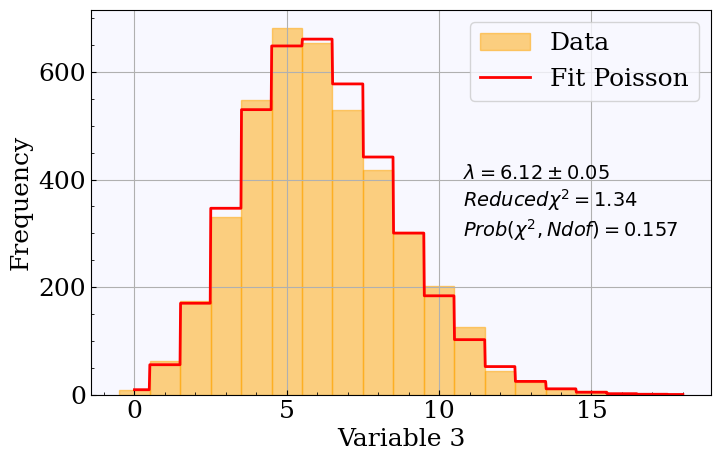

In [26]:
# Plot the second fit with the fit parameters

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

hist = ax.hist(x3, bins=np.arange(-0.5, x3.max(), 1), alpha=0.5, edgecolor='orange', label='Data')
bw = hist[1][1] - hist[1][0]
ax.plot(x3_arr, len(x3) * bw * func3(np.floor(x3_arr+0.5), *m3.values[:]), lw=2, label='Fit Poisson')

ax.set(xlabel='Variable 3',
         ylabel='Frequency')
ax.legend()

textstr = '\n'.join((
    r'$\lambda=%.2f \pm %.2f$' % (m3.values[0], m3.errors[0]),
    r'$Reduced \chi^2=%.2f$' % (chi2_reduced2),
    r'$Prob(\chi^2, Ndof)=%.3f$' % (prob2)))

ax.text(0.6, 0.6, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

if save_plots:
    plt.savefig('Figures/Prob1_Fit2.pdf')

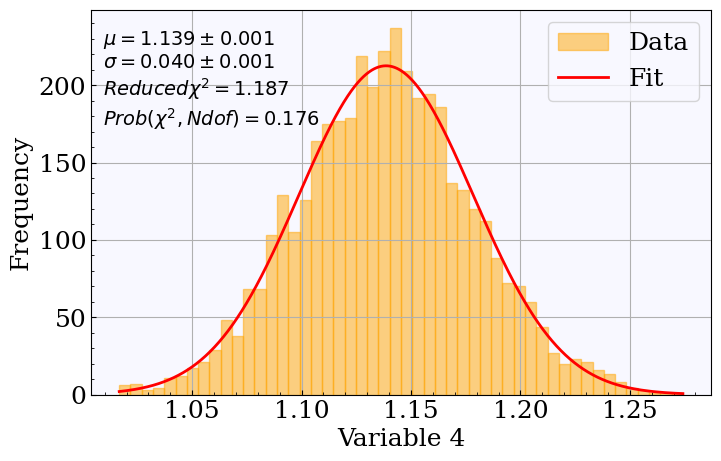

In [24]:
# Plot the third fit with the fit parameters

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

hist = ax.hist(x4, bins=50, alpha=0.5, edgecolor='orange', label='Data')
bw = hist[1][1] - hist[1][0]
ax.plot(x4_arr, len(x4) * bw * func4(x4_arr, *m4.values[:]), lw=2, label='Fit')

ax.set(xlabel='Variable 4',
            ylabel='Frequency')
ax.legend()

textstr = '\n'.join((
    r'$\mu=%.3f \pm %.3f$' % (m4.values[0], m4.errors[0]),
    r'$\sigma=%.3f \pm %.3f$' % (m4.values[1], m4.errors[1]),
    r'$Reduced \chi^2=%.3f$' % (chi2_reduced3),
    r'$Prob(\chi^2, Ndof)=%.3f$' % (prob3)))

ax.text(0.02, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

if save_plots:
    plt.savefig('Figures/Prob1_Fit3.pdf')